In [15]:
# # ! pip install imbalanced-learn
# # ! pip install lime
# # ! pip install textblob
# # ! pip install contractions
# # ! pip install spacy
# # ! python -m spacy download en_core_web_sm
# # ! pip install gensim
# ! pip install python-Levenshtein

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns

import pickle 
import imblearn
from imblearn.over_sampling import SMOTE
from collections import Counter
import time

import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
# import lime
# import lime.lime_tabular

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, plot_confusion_matrix

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA, IncrementalPCA, LatentDirichletAllocation

from helpers import *

## Load cleaned data
combine title and body of text 

In [10]:
aita_2 = pd.read_csv('data/aita_save2.csv')

In [11]:
aita = aita_2.dropna(subset=['body_clean', 'title_clean']).loc[:,['body_polarity','body_subjectivity','is_asshole','score','num_comments']]
aita['title_body_combo'] =  aita_3['title_clean'] + aita_3['body_clean']
aita = aita[(aita['score'] >= 10) & (aita['num_comments']>= 10)]
aita.dropna(inplace=True)
aita.reset_index(drop=True)

,body_polarity,body_subjectivity,is_asshole,score,num_comments,title_body_combo
0,-0.156818,0.656818,1,52,13.0,I write an explanation in til and come off a...
1,0.034848,0.449242,1,140,27.0,throw my parent donut awaymy parent be diabe...
2,0.000000,0.000000,0,74,15.0,I tell a goth girl she look like a clownI be four
3,0.000000,0.700000,1,12,14.0,atia I permanently give a customer decafhis na...
4,-0.034226,0.395982,1,14,18.0,give my friend some peanut ask for some late...
...,...,...,...,...,...,...
23141,0.070667,0.479542,0,10,12.0,for not want to reconcile with one of my ex ...
23142,0.192381,0.485714,0,11,17.0,for want to go out on my birthdayI recently ...
23143,-0.126852,0.465741,1,67,54.0,for yell at my daughter have be help dau...
23144,0.016111,0.385278,0,16,23.0,for tell my sister she be be a spoiled bratm...


## 1 - train test split

In [15]:
X = aita.drop('is_asshole', axis=1)
y = aita['is_asshole']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.01, random_state=21)
print(X_train.shape, X_test.shape)

(22914, 5) (232, 5)


In [16]:
Counter(y)

Counter({1: 6407, 0: 16739})

## 2 - Instantiate CountVectorizer 

In [17]:
# add_stop_words = ['like', 'get', 'go', 'say', 'tell', 'thats', 'want', 'time',
#                   'youre', 'got', 'gonna', 'time', 'also', 'yeah', 'said']
# stop = set(stopwords.words('english')).union(add_stop_words)
# vec = CountVectorizer(stop_words=stop, min_df=0.005, max_df=0.8, ngram_range=(1, 2))
# cv = vec.fit(X_train['title_body_combo'])
# len(cv.get_feature_names())
# # 3221

3221

In [18]:
# pickle.dump(cv, open('models/cv_fit_train_min10.sav', 'wb'))
cv = pickle.load(open('models/cv_fit_train_min10.sav', 'rb'))
len(cv.get_feature_names())

### 2.a Transform train and test data into document-term-matrix with CountVectorizer

In [19]:
cv_train = cv.transform(X_train['title_body_combo'])
cv_test = cv.transform(X_test['title_body_combo'])
cv_cols = cv.get_feature_names()
dtm_train = pd.DataFrame(cv_train.toarray(), columns=cv_cols, index=X_train.index)
dtm_test = pd.DataFrame(cv_test.toarray(), columns=cv_cols, index=X_test.index)

In [20]:
dtm_train.shape, dtm_test.shape

((22914, 3221), (232, 3221))

## 3 - PCA

In [21]:
# pca = IncrementalPCA(n_components=1000, batch_size=1050)
# pca.fit(dtm_train)
# print(pca.explained_variance_ratio_.sum())

0.8858948258154675


In [22]:
# pickle.dump(pca, open('models/pca_min10.sav', 'wb'))
# # pca = pickle.load(open('models/pca_min10.sav', 'rb'))
# print(pca.get_params)
# print(pca.explained_variance_ratio_.sum())
# # 0.8858948258154675

<bound method BaseEstimator.get_params of IncrementalPCA(batch_size=1050, n_components=1000)>
0.8858948258154675


#### 3.a Scree plot, check number of components is appropriate

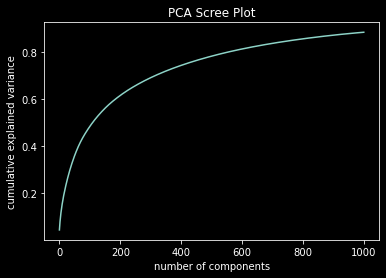

In [23]:
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance')
# plt.title('PCA Scree Plot')
# evr = pca.explained_variance_ratio_
# cvr = np.cumsum(pca.explained_variance_ratio_)
# pca_df = pd.DataFrame()
# pca_df['Cumulative Variance Ratio'] = cvr
# pca_df['Explained Variance Ratio'] = evr

### 3.b - Transform train/test Document-Term-matrix with PCA

In [24]:
# dtm_train_pca = pca.transform(dtm_train)
# dtm_test_pca = pca.transform(dtm_test)

In [25]:
# # Build DataFrame of PCA Components
# col_names = ['PC_' + str(i) for i in range(1, pca.get_params()['n_components']+1)]
# dtm_train_pca_df = pd.DataFrame(dtm_train_pca, columns=col_names, index=dtm_train.index)
# dtm_test_pca_df = pd.DataFrame(dtm_test_pca, columns=col_names, index=dtm_test.index)

In [26]:
# # Combine PCA components and sentiment analysis scores into one DataFrame
# X_train_post_dtm_pca = pd.concat([X_train[['body_polarity','body_subjectivity']], dtm_train_pca_df], axis=1)
# X_test_post_dtm_pca = pd.concat([X_test[['body_polarity','body_subjectivity']],dtm_test_pca_df], axis=1)

## 4 Oversample minority class with SMOTE

In [29]:
# # sentiment analysis + PCA
# X_train_smote, y_train_smote = SMOTE().fit_resample(X_train_post_dtm_pca, y_train)
# X_test_smote, y_test_smote = SMOTE().fit_resample(X_test_post_dtm_pca, y_test)
# Counter(y_train_smote), Counter(y_test_smote)

(Counter({1: 16571, 0: 16571}), Counter({1: 168, 0: 168}))

In [ ]:
# DTM 
X_train_dtm_smote, y_train_smote = SMOTE().fit_resample(dtm_train, y_train)
X_test_dtm_smote, y_test_smote = SMOTE().fit_resample(dtm_test, y_test)

In [107]:
# sentiment analysis + DTM
X_train_dtm_sen = pd.concat([X_train[['body_polarity','body_subjectivity']], dtm_train], axis=1)
X_test_dtm_sen = pd.concat([X_test[['body_polarity','body_subjectivity']], dtm_test], axis=1)
X_train_dtm_sen_smote, y_train_smote = SMOTE().fit_resample(X_train_dtm_sen, y_train)
X_test_dtm_sen_smote, y_test_smote = SMOTE().fit_resample(X_test_dtm_sen, y_test)

# Models

## 1 - Logistic Regression

#### 1.b LR with DTM

In [119]:
start = time.time()
lr_dtm = LogisticRegression(max_iter=800, penalty='l2', solver='lbfgs')
lr_dtm.fit(X_train_dtm_smote, y_train_smote)
end = time.time()
print(f'run time = {(end-start)/60} mins')
print('train smote')
y_pred_train = lr_dtm.predict(X_train_dtm_smote)
print(f'F1 Score = {f1_score(y_train_smote,y_pred_train):{n}f}')
print(f'Accuracy Score = {accuracy_score(y_train_smote,y_pred_train):{n}f}')
print('test smote')
y_pred_test = lr_dtm.predict(X_test_dtm_smote)
print(f'F1 Score = {f1_score(y_test_smote,y_pred_test):{n}f}')
print(f'Accuracy Score = {accuracy_score(y_test_smote,y_pred_test):{n}f}')
print('train no smote')
y_pred_train = lr_dtm.predict(dtm_train)
print(f'F1 Score = {f1_score(y_train,y_pred_train):{n}f}')
print(f'Accuracy Score = {accuracy_score(y_train,y_pred_train):{n}f}')
print('test no smote')
y_pred_test = lr_dtm.predict(dtm_test)
print(f'F1 Score = {f1_score(y_test,y_pred_test):{n}f}')
print(f'Accuracy Score = {accuracy_score(y_test,y_pred_test):{n}f}')

train smote
F1 Score = 0.805
Accuracy Score = 0.803
test smote
F1 Score = 0.740
Accuracy Score = 0.738
train no smote
F1 Score = 0.498
Accuracy Score = 0.716
test no smote
F1 Score = 0.373
Accuracy Score = 0.638


#### 1.c LR with DTM and Sentiment Analysis

In [113]:
start = time.time()
lr_dtm_sen = LogisticRegression(max_iter=800, penalty='l2', solver='lbfgs')
lr_dtm_sen.fit(X_train_dtm_sen_smote, y_train_smote)
end = time.time()
print(f'run time = {(end-start)/60} mins')
print('- train smote -')
y_pred_train = lr_dtm_sen.predict(X_train_dtm_sen_smote)
print(f'F1 Score = {f1_score(y_train_smote,y_pred_train):{n}f}')
print(f'Accuracy Score = {accuracy_score(y_train_smote,y_pred_train):{n}f}')
print('- test smote -')
y_pred_test = lr_dtm_sen.predict(X_test_dtm_sen_smote)
print(f'F1 Score = {f1_score(y_test_smote,y_pred_test):{n}f}')
print(f'Accuracy Score = {accuracy_score(y_test_smote,y_pred_test):{n}f}')
print('- train no smote -')
y_pred_train = lr_dtm_sen.predict(X_train_dtm_sen)
print(f'F1 Score = {f1_score(y_train,y_pred_train):{n}f}')
print(f'Accuracy Score = {accuracy_score(y_train,y_pred_train):{n}f}')
print('- test no smote -')
y_pred_test = lr_dtm_sen.predict(X_test_dtm_sen)
print(f'F1 Score = {f1_score(y_test,y_pred_test):{n}f}')
print(f'Accuracy Score = {accuracy_score(y_test,y_pred_test):{n}f}')

train smote
F1 Score = 0.805
Accuracy Score = 0.804
test smote
F1 Score = 0.754
Accuracy Score = 0.753
train no smote
F1 Score = 0.498
Accuracy Score = 0.718
test no smote
F1 Score = 0.394
Accuracy Score = 0.655


## 2 - Random Forest Model

In [128]:
start = time.time()
rfc_sen = RandomForestClassifier(n_jobs=-1,min_samples_split=3)
rfc_sen.fit(X_train_dtm_sen_smote, y_train_smote)
end = time.time()
print((end-start)/60)
print('train smote')
y_pred_train = rfc_sen.predict(X_train_dtm_sen_smote)
print(f'F1 Score = {f1_score(y_train_smote,y_pred_train):{n}f}')
print(f'Accuracy Score = {accuracy_score(y_train_smote,y_pred_train):{n}f}')
print('test smote')
y_pred_test = rfc_sen.predict(X_test_dtm_sen_smote)
print(f'F1 Score = {f1_score(y_test_smote,y_pred_test):{n}f}')
print(f'Accuracy Score = {accuracy_score(y_test_smote,y_pred_test):{n}f}')
print('train no smote')
y_pred_train = rfc_sen.predict(X_train_dtm_sen)
print(f'F1 Score = {f1_score(y_train,y_pred_train):{n}f}')
print(f'Accuracy Score = {accuracy_score(y_train,y_pred_train):{n}f}')
print('test no smote')
y_pred_test = rfc_sen.predict(X_test_dtm_sen)
print(f'F1 Score = {f1_score(y_test,y_pred_test):{n}f}')
print(f'Accuracy Score = {accuracy_score(y_test,y_pred_test):{n}f}')

train smote
F1 Score = 1.000
Accuracy Score = 1.000
test smote
F1 Score = 0.735
Accuracy Score = 0.756
train no smote
F1 Score = 1.000
Accuracy Score = 1.000
test no smote
F1 Score = 0.231
Accuracy Score = 0.655


In [174]:
# pickle.dump(rfc_sen, open('models/rfc_sen.sav', 'wb'))

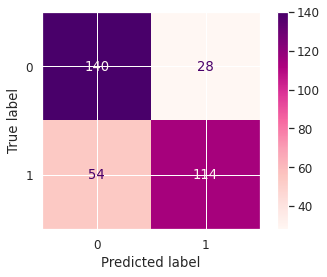

In [288]:
plot_confusion_matrix(rfc_sen, X_test_dtm_sen_smote, y_test_smote, cmap='RdPu');

## 3. Naive Bayes

In [96]:
start = time.time()
nb = MultinomialNB()
nb.fit(X_train_dtm_smote, y_train_smote)
end = time.time()
print((end-start)/60)
print('train smote')
y_pred_train = nb.predict(X_train_dtm_smote)
print(f'F1 Score = {f1_score(y_train_smote,y_pred_train):{n}f}')
print(f'Accuracy Score = {accuracy_score(y_train_smote,y_pred_train):{n}f}')
print('test smote')
y_pred_test = nb.predict(X_test_dtm_smote)
print(f'F1 Score = {f1_score(y_test_smote,y_pred_test):{n}f}')
print(f'Accuracy Score = {accuracy_score(y_test_smote,y_pred_test):{n}f}')
print('train no smote')
y_pred_train = nb.predict(dtm_train)
print(f'F1 Score = {f1_score(y_train,y_pred_train):{n}f}')
print(f'Accuracy Score = {accuracy_score(y_train,y_pred_train):{n}f}')
print('test no smote')
y_pred_test = nb.predict(dtm_test)
print(f'F1 Score = {f1_score(y_test,y_pred_test):{n}f}')
print(f'Accuracy Score = {accuracy_score(y_test,y_pred_test):{n}f}')

train smote
F1 Score = 0.730
Accuracy Score = 0.726
test smote
F1 Score = 0.737
Accuracy Score = 0.735
train no smote
F1 Score = 0.446
Accuracy Score = 0.653
test no smote
F1 Score = 0.493
Accuracy Score = 0.681


## 4 - Support Vector Machines (SVM)

In [286]:
# start = time.time()
# SGD = SGDClassifier()
# SGD.fit(X_train_dtm_smote, y_train_smote)
# end = time.time()
print((end-start)/60)
print('train smote')
y_pred_train = SGD.predict(X_train_dtm_smote)
print(f'F1 Score = {f1_score(y_train_smote,y_pred_train):{n}f}')
print(f'Accuracy Score = {accuracy_score(y_train_smote,y_pred_train):{n}f}')
print('test smote')
y_pred_test = SGD.predict(X_test_dtm_smote)
print(f'F1 Score = {f1_score(y_test_smote,y_pred_test):{n}f}')
print(f'Accuracy Score = {accuracy_score(y_test_smote,y_pred_test):{n}f}')
print('train no smote')
y_pred_train = SGD.predict(dtm_train)
print(f'F1 Score = {f1_score(y_train,y_pred_train):{n}f}')
print(f'Accuracy Score = {accuracy_score(y_train,y_pred_train):{n}f}')
print('test no smote')
y_pred_test = SGD.predict(dtm_test)
print(f'F1 Score = {f1_score(y_test,y_pred_test):{n}f}')
print(f'Accuracy Score = {accuracy_score(y_test,y_pred_test):{n}f}')

0.40811178684234617
train smote
F1 Score = 0.811
Accuracy Score = 0.820
test smote
F1 Score = 0.762
Accuracy Score = 0.771
train no smote
F1 Score = 0.476
Accuracy Score = 0.744
test no smote
F1 Score = 0.413
Accuracy Score = 0.694


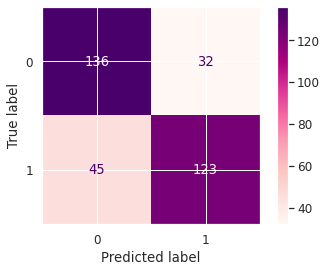

In [287]:
plot_confusion_matrix(SGD, X_test_dtm_smote, y_test_smote, cmap='RdPu');

In [262]:
# start = time.time()
# SGD_sen = SGDClassifier()
# SGD_sen.fit(X_train_dtm_sen_smote, y_train_smote)
# end = time.time()
# print((end-start)/60)
print('train smote')
y_pred_train = SGD_sen.predict(X_train_dtm_sen_smote)
print(f'F1 Score = {f1_score(y_train_smote,y_pred_train):{n}f}')
print(f'Accuracy Score = {accuracy_score(y_train_smote,y_pred_train):{n}f}')
print('test smote')
y_pred_test = SGD_sen.predict(X_test_dtm_sen_smote)
print(f'F1 Score = {f1_score(y_test_smote,y_pred_test):{n}f}')
print(f'Accuracy Score = {accuracy_score(y_test_smote,y_pred_test):{n}f}')
print('train no smote')
y_pred_train = SGD_sen.predict(X_train_dtm_sen)
print(f'F1 Score = {f1_score(y_train,y_pred_train):{n}f}')
print(f'Accuracy Score = {accuracy_score(y_train,y_pred_train):{n}f}')
print('test no smote')
y_pred_test = SGD_sen.predict(X_test_dtm_sen)
print(f'F1 Score = {f1_score(y_test,y_pred_test):{n}f}')
print(f'Accuracy Score = {accuracy_score(y_test,y_pred_test):{n}f}')

train smote
F1 Score = 0.807
Accuracy Score = 0.815
test smote
F1 Score = 0.738
Accuracy Score = 0.738
train no smote
F1 Score = 0.477
Accuracy Score = 0.737
test no smote
F1 Score = 0.351
Accuracy Score = 0.634


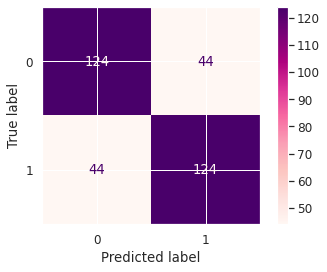

In [283]:
plot_confusion_matrix(SGD_sen, X_test_dtm_sen_smote, y_test_smote,cmap='RdPu');

# Testing

In [132]:
aita_clean = pd.read_csv('data/aita_clean.csv')

In [253]:
tops = aita_clean[['title','body','verdict','is_asshole','score']].sort_values('score', ascending=False).head(500)

In [460]:
diag_tops = Proctologist(model=SGD_sen, sentiment=True).diagnosis(tops['body'].values)
diag_tops['true_verdict'] = tops['is_asshole'].values
diag_tops['correct_prediction'] = diag_tops['true_verdict'] == diag_tops['asshole']
sum(diag_tops.correct_prediction)/len(diag_tops.correct_prediction)

0.742

In [177]:
diag_tops = Proctologist(model=SGD, sentiment=False).diagnosis(tops['body'].values)
diag_tops['true_verdict'] = tops['is_asshole'].values
diag_tops['correct_prediction'] = diag_tops['true_verdict'] == diag_tops['asshole']
sum(diag_tops.correct_prediction)/len(diag_tops.correct_prediction)

0.72

In [178]:
# diag_tops = Proctologist(model=nb, sentiment=False).diagnosis(tops['body'].values)
# diag_tops['true_verdict'] = tops['is_asshole'].values
# diag_tops['correct_prediction'] = diag_tops['true_verdict'] == diag_tops['asshole']
# sum(diag_tops.correct_prediction)/len(diag_tops.correct_prediction)

0.608

In [179]:
diag_tops = Proctologist(model=rfc_sen, sentiment=True).diagnosis(tops['body'].values)
diag_tops['true_verdict'] = tops['is_asshole'].values
diag_tops['correct_prediction'] = diag_tops['true_verdict'] == diag_tops['asshole']
sum(diag_tops.correct_prediction)/len(diag_tops.correct_prediction)

0.852

In [180]:
diag_tops = Proctologist(model=lr_dtm, sentiment=False).diagnosis(tops['body'].values)
diag_tops['true_verdict'] = tops['is_asshole'].values
diag_tops['correct_prediction'] = diag_tops['true_verdict'] == diag_tops['asshole']
sum(diag_tops.correct_prediction)/len(diag_tops.correct_prediction)

0.69

In [181]:
diag_tops = Proctologist(model=lr_dtm_sen, sentiment=True).diagnosis(tops['body'].values)
diag_tops['true_verdict'] = tops['is_asshole'].values
diag_tops['correct_prediction'] = diag_tops['true_verdict'] == diag_tops['asshole']
sum(diag_tops.correct_prediction)/len(diag_tops.correct_prediction)

0.686

## Testing with fake conflict

Random Forest with sentiment

In [289]:
# texts = ['I pushed my mom off a cliff after she said she will buy me a playstation 5, and my whole family is mad at me, but I don\'t feel bad about it, aita?',
#         'I found out my boyfriend cheated on me with my bestfriend, I can hardly believe they would betray me like this under my eye. I cut contact with them both after they showed no remorse. But our mutual friends are saying I should be happy for them',
#         'I cheated on my boyfriend and he kicked me out of his house, I broke in in the middle of night, I did not pay rent.',
#          'I talked to my ex on a regular basis, my girlfriend doesn\'t know about it, and she isn\'t happy about it, she said she\'s going to leave me',
#         "I am 27(f) and my husband is 26 So for those who don't know playboi carti is a 'rapper' who dresses pretty feminine and talks pretty strange (His music is interesting, to say the least). So recently my husband began listening to Carti and other artists at first I didn't care because I'm not controlling I let him listen to what he wants. but starting last week my husband began spending large sums on money on designer clothes like the ones playboi carti wears I was a bit annoyed but it was his money. But what really pissed me off is that he started talking like carti saying things like \"slatt\" \"slime\" and other slang words that are pretty strange for a suburban white man to say. I've told him multiple times that I don't like this new him but he continues to do these things he only listens to Playboi carti and I think his music is starting to brainwash him? WIBTA if I imposed a ban on listening to Carti's music for a while so my husband can get a better handle on himself and stop buying thousands of dollars worth of Rick Owens. I'm worrying that maybe it would be controlling and maybe a bit crazy if I did.",
#         'AITA for telling my stepdaughter to stop using period products in the bathroom she shares with my teenage sons?']
# true_verdict = [1,0,1,1,1,1]

In [461]:
texts=["""
My boyfriend lived rent free with me, he cheated on me with my high school friend, I found out and kicked him out of the house. He broke in in the middle of the night, I was angry and said I was going to call the police.
"""]
true_verdict = [0]

SGD without sentiment

In [462]:
diag = Proctologist(model=SGD_sen, sentiment=True).diagnosis(texts)
diag['true_verdict'] = true_verdict
diag['correct_prediction'] = diag['true_verdict'] == diag['asshole']
# sum(diag.correct_prediction)/len(diag.correct_prediction)
diag

,text,asshole,true_verdict,correct_prediction
0,"\nMy boyfriend lived rent free with me, he che...",1,0,False


In [463]:
diag_rfc = Proctologist(model=rfc_sen, sentiment=True).diagnosis(texts)
diag_rfc['true_verdict'] = true_verdict
diag_rfc['correct_prediction'] = diag_rfc['true_verdict'] == diag_rfc['asshole']
diag_rfc

,text,asshole,true_verdict,correct_prediction
0,"\nMy boyfriend lived rent free with me, he che...",1,0,False


In [464]:
diag_SGD = Proctologist(model=SGD, sentiment=False).diagnosis(texts)
diag_SGD['true_verdict'] = true_verdict
diag_SGD['correct_prediction'] = diag_SGD['true_verdict'] == diag_SGD['asshole']
diag_rfc

,text,asshole,true_verdict,correct_prediction
0,"\nMy boyfriend lived rent free with me, he che...",1,0,False


In [465]:
diag = Proctologist(model=lr_dtm, sentiment=False).diagnosis(texts)
diag['true_verdict'] = true_verdict
diag['correct_prediction'] = diag['true_verdict'] == diag['asshole']
diag

,text,asshole,true_verdict,correct_prediction
0,"\nMy boyfriend lived rent free with me, he che...",1,0,False
